In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import pickle as p
import equinox as eqx
import optax
import functools as ft

In [3]:
from dLux import *
from helpers import *
from bayes import *

from tqdm.notebook import tqdm
from dLux.zernike import zernike_basis
from model_layers import toliman_layers
from chainconsumer import ChainConsumer

In [4]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120
# plt.rcParams.keys()

<Figure size 432x288 with 0 Axes>

In [5]:
Nstars = 15
Nims = 5
Nwavels = 3

onp.random.seed(3)
positions = 1e-4*(2*unif_rand([Nstars, 2])-1)
fluxes = norm_rand(1e8, 1e7, Nstars)
wavels = 1e-9 * np.linspace(545, 645, Nwavels)
dithers = 1e-5 * np.array([[0,   0],
                           [+1, +1],
                           [+1, -1],
                           [-1, +1],
                           [-1, -1]])

In [6]:
# Base layers
lays = toliman_layers()
aperture = lays[2].array
wf_npix = aperture.shape[0]
det_npix = lays[-1].npix_out

# Masks
mask = np.load("files/binary_mask.npy") * (wavels.mean()/(2*np.pi))

# Zernike Basis
zern_basis = zernike_basis(10, wf_npix, outside=0.)[3:]
zcoeffs = 2.5e-8 * norm_rand(0, 0.5, len(zern_basis))

pix_response = norm_rand(1, 0.05, [det_npix, det_npix])
det_layers = [ApplyPixelResponse(pix_response)]
BG_noise = np.abs(norm_rand(0, 5, [Nims, det_npix, det_npix]))

In [7]:
# Test Osys
layers = toliman_layers([
                ApplyOPD(mask),
                ApplyBasisOPD(zern_basis, zcoeffs)])

osys = OpticalSystem(layers, 
                        wavels=wavels, 
                        positions=positions, 
                        fluxes=fluxes,
                        dithers=dithers,
                        detector_layers=det_layers)

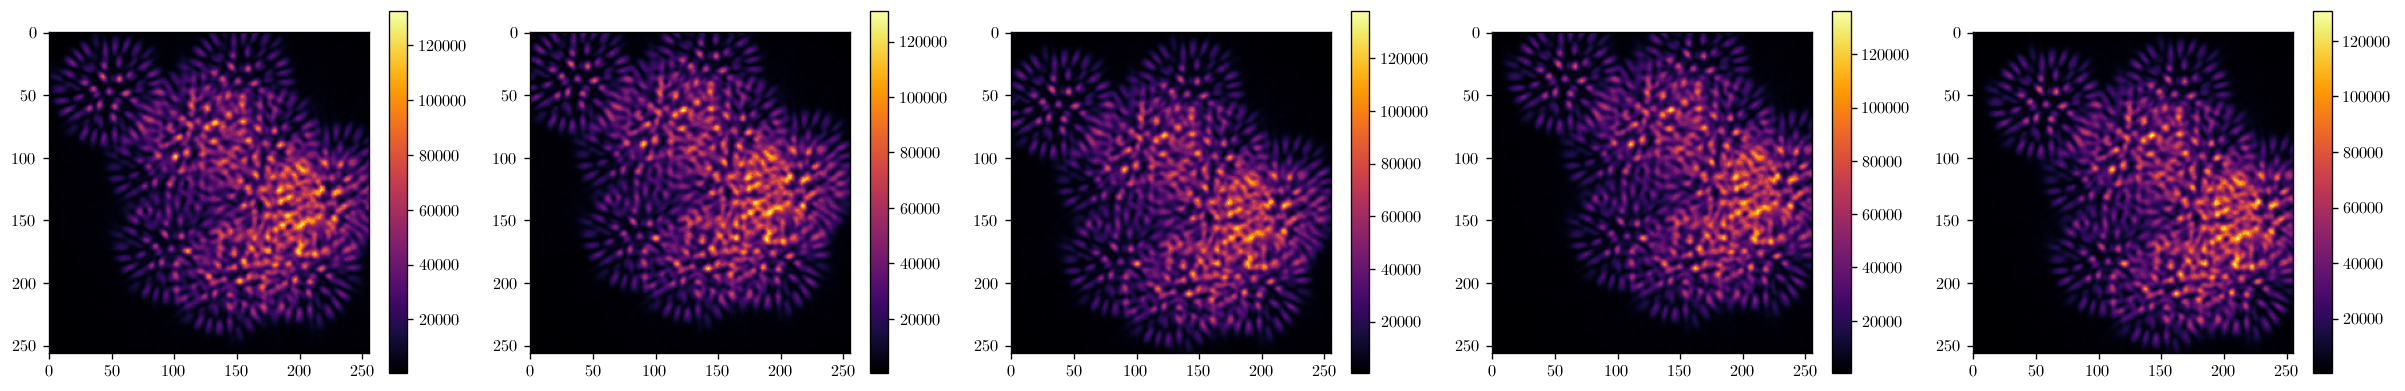

In [8]:
psfs = onp.random.poisson(osys()) + BG_noise
data = psfs

plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(psfs[i])
    plt.colorbar()
plt.show()

In [9]:
# Construct initial model
coeffs_init = np.zeros([len(zern_basis)])
positions_init = positions + 0.5e-6*norm_rand(0, 0.2, [Nstars, 2])
fluxes_init = fluxes * norm_rand(1, 0.1, [Nstars])
det_layers_init = [ApplyPixelResponse(np.ones([det_npix, det_npix]))]

layers = toliman_layers([
                ApplyOPD(mask),
                ApplyBasisOPD(zern_basis, coeffs_init)])

opt_model = OpticalSystem(layers, 
                        wavels=wavels, 
                        positions=positions_init, 
                        fluxes=fluxes_init,
                        dithers=dithers,
                        detector_layers=det_layers_init)

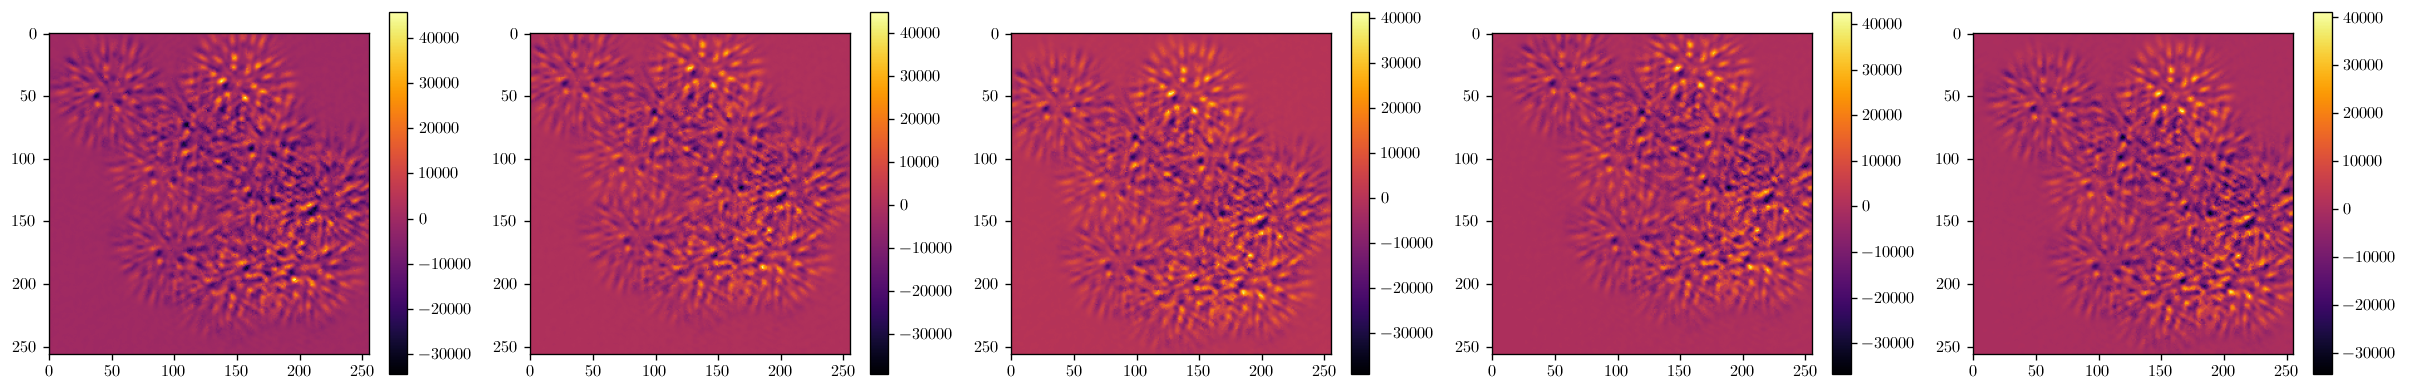

In [10]:
psfs = opt_model()

plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(psfs[i] - data[i])
    plt.colorbar()
plt.show()

In [11]:
model = [opt_model]

# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, model)

# Set filtering Tree
filter_spec = eqx.tree_at(lambda osys: osys[0].positions,                         filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda osys: osys[0].fluxes,                            filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda osys: osys[0].layers[-2].coeffs,                 filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda osys: osys[0].detector_layers[0].pixel_response, filter_spec, replace=True)

In [12]:
@eqx.filter_jit
@ft.partial(eqx.filter_value_and_grad, filter_spec=filter_spec)
def loss_func(model, data):
    out = model[0]()
    return -np.sum(poisson.logpmf(data, out))

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/equinox/grad.py:71: UserWarning: For brevity the `filter_spec` argument has been renamed `arg`
  warnings.warn("For brevity the `filter_spec` argument has been renamed `arg`")


In [13]:
%%time
loss, grads = loss_func(model, data) # Compile

print("Initial Loss: {}".format(int(loss)))

Initial Loss: 190255951
CPU times: user 7.38 s, sys: 271 ms, total: 7.65 s
Wall time: 2.21 s


In [14]:
param_spec =  jax.tree_map(lambda _: "null", model)

# Set parameter groups
param_spec = eqx.tree_at(lambda osys: osys[0].positions,                         param_spec, replace='positions')
param_spec = eqx.tree_at(lambda osys: osys[0].fluxes,                            param_spec, replace='fluxes')
param_spec = eqx.tree_at(lambda osys: osys[0].layers[-2].coeffs,                 param_spec, replace='coeffs')
param_spec = eqx.tree_at(lambda osys: osys[0].detector_layers[0].pixel_response, param_spec, replace='FF')

# Set LRs
pos_lr   = 2e-8
flux_lr  = 1e6
coeff_lr = 2e-9
FF_lr    = 1e-2

FF_init  = 100
FF_sched = optax.piecewise_constant_schedule(init_value=1e-12*FF_lr, boundaries_and_scales={FF_init :int(1e12)})

optim = optax.multi_transform(
    {"null":        optax.adam(0.0),
     "positions":   optax.adam(pos_lr),
     "fluxes":      optax.adam(flux_lr),
     "coeffs":      optax.adam(coeff_lr),
     "FF":          optax.adam(FF_sched)},
    param_spec)

opt_state = optim.init(model)

In [15]:
errors, grads_out, models_out = [], [], []

model_out = [opt_model] # Re-initialise Model
for i in tqdm(range(200)):
    loss, grads = loss_func(model_out, data)    

    updates, opt_state = optim.update(grads, opt_state)
    model_out = eqx.apply_updates(model_out, updates)
    errors.append(loss)
    grads_out.append(grads)
    models_out.append(model_out)
    
    if i<10 or i%10 == 0:
        print("Epoch: {} \tlog10 loss: {:.4f} \tloss: {:.0f}".format(i, np.log10(loss), loss))

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 	log10 loss: 8.2793 	loss: 190255951
Epoch: 1 	log10 loss: 8.2015 	loss: 159038488
Epoch: 2 	log10 loss: 8.1144 	loss: 130145808
Epoch: 3 	log10 loss: 8.0208 	loss: 104904247
Epoch: 4 	log10 loss: 7.9240 	loss: 83939341
Epoch: 5 	log10 loss: 7.8305 	loss: 67683541
Epoch: 6 	log10 loss: 7.7455 	loss: 55649823
Epoch: 7 	log10 loss: 7.6711 	loss: 46895235
Epoch: 8 	log10 loss: 7.6060 	loss: 40366567
Epoch: 9 	log10 loss: 7.5445 	loss: 35032475
Epoch: 10 	log10 loss: 7.4801 	loss: 30208634
Epoch: 20 	log10 loss: 7.2443 	loss: 17550221
Epoch: 30 	log10 loss: 7.0687 	loss: 11715037
Epoch: 40 	log10 loss: 7.0292 	loss: 10694393
Epoch: 50 	log10 loss: 7.0010 	loss: 10023673
Epoch: 60 	log10 loss: 6.9920 	loss: 9818426
Epoch: 70 	log10 loss: 6.9899 	loss: 9769526
Epoch: 80 	log10 loss: 6.9875 	loss: 9716716
Epoch: 90 	log10 loss: 6.9872 	loss: 9710520
Epoch: 100 	log10 loss: 6.9872 	loss: 9708810
Epoch: 110 	log10 loss: 6.4924 	loss: 3107289
Epoch: 120 	log10 loss: 6.4620 	loss: 289723

In [16]:
p.dump(models_out, open('files/post_calibration_models.p', 'wb'))
# models_out = p.load(open('files/post_calibration_models.p', 'rb'))

In [17]:
nepochs = len(models_out)
psfs_out = model_out[0]()

positions_found = np.array([models_out[i][0].positions                          for i in range(nepochs)])
fluxes_found =    np.array([models_out[i][0].fluxes                             for i in range(nepochs)])
coeffs_found =    np.array([models_out[i][0].layers[-2].coeffs                  for i in range(nepochs)])
prs_found =       np.array([models_out[i][0].detector_layers[0].pixel_response  for i in range(nepochs)])

In [18]:
final_model = model_out[0]
errors = np.array(errors)

coeff_residuals = zcoeffs - coeffs_found
flux_residuals = fluxes - fluxes_found

scaler = 1e3
positions_residuls = positions - positions_found
r_residuals_rads = np.hypot(positions_residuls[:, :, 0], positions_residuls[:, :, 1])
r_residuals = rad2arcsec(r_residuals_rads)

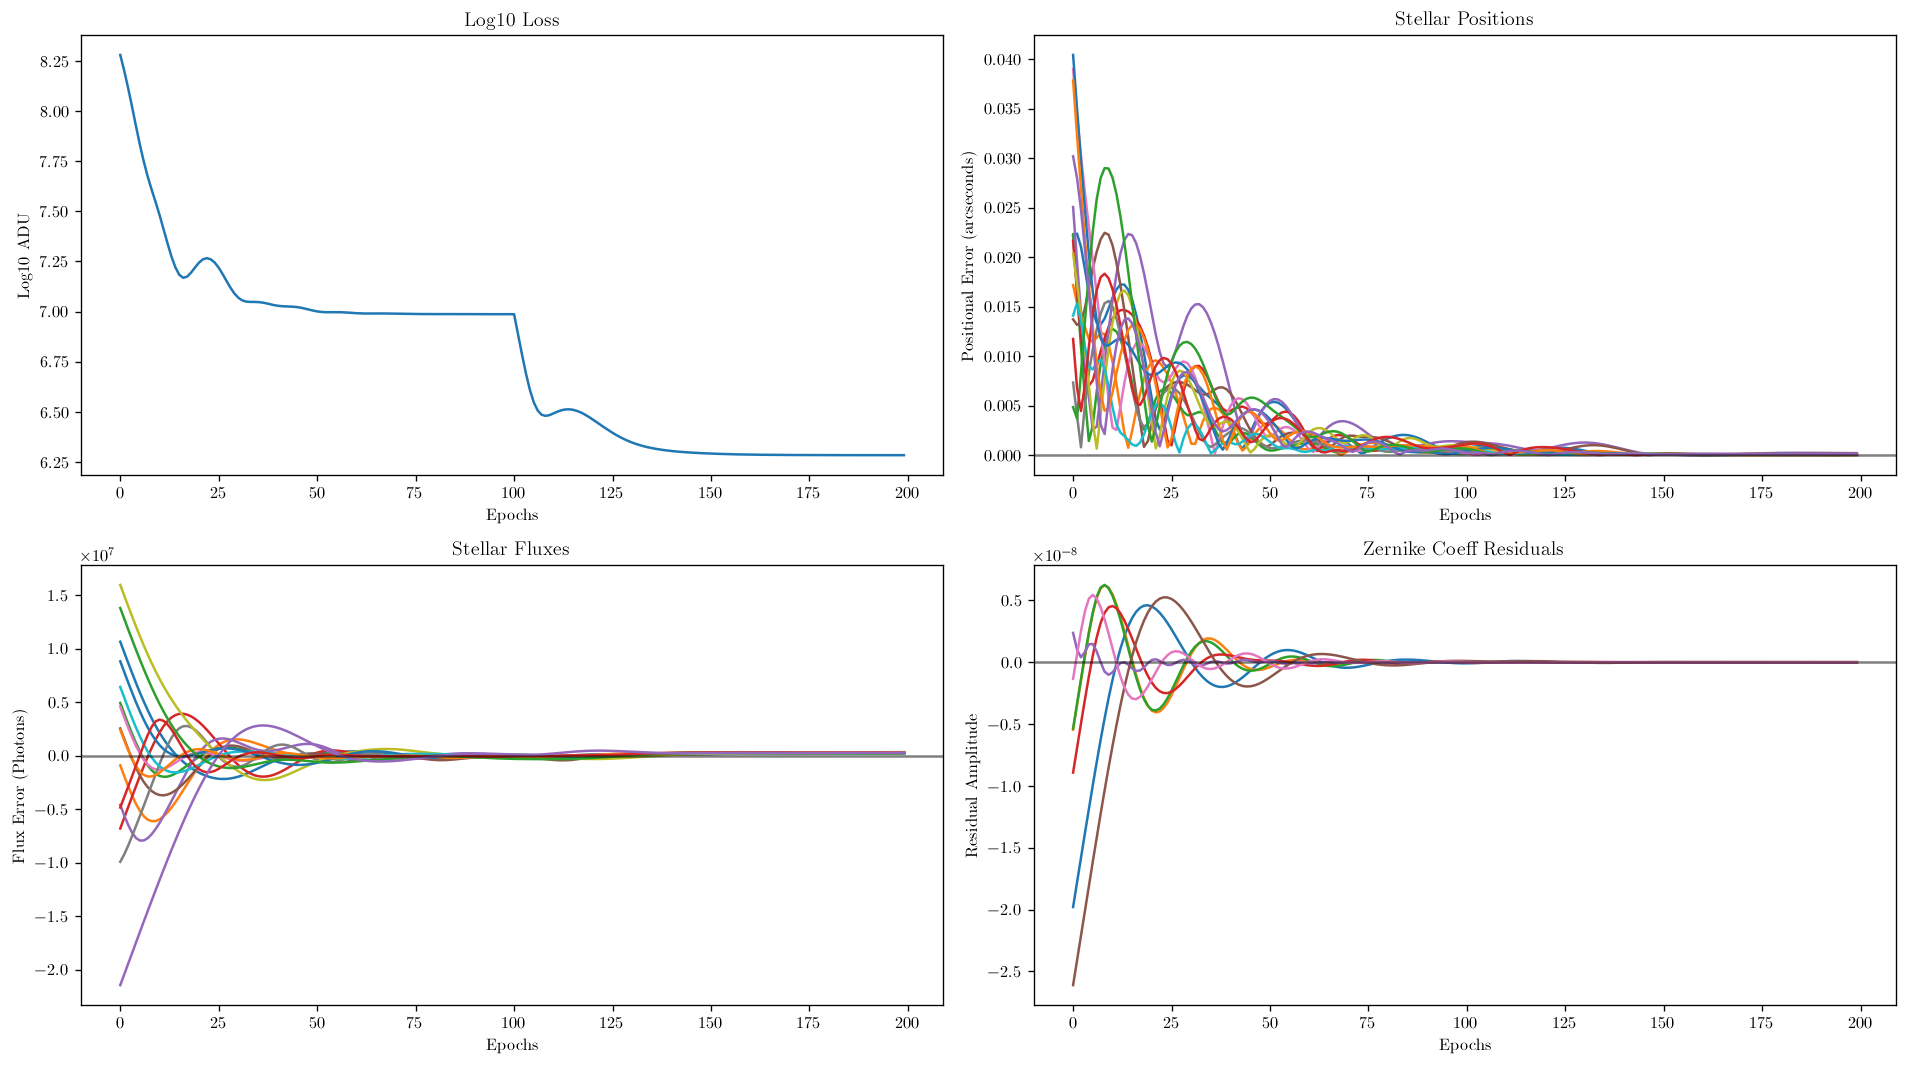

In [19]:
j = len(models_out)
plt.figure(figsize=(16, 13))

plt.subplot(3, 2, 1)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(errors[:j]))

plt.subplot(3, 2, 2)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 3)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(flux_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 4)
plt.title("Zernike Coeff Residuals")
plt.xlabel("Epochs")
plt.ylabel("Residual Amplitude")
plt.plot(coeff_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()

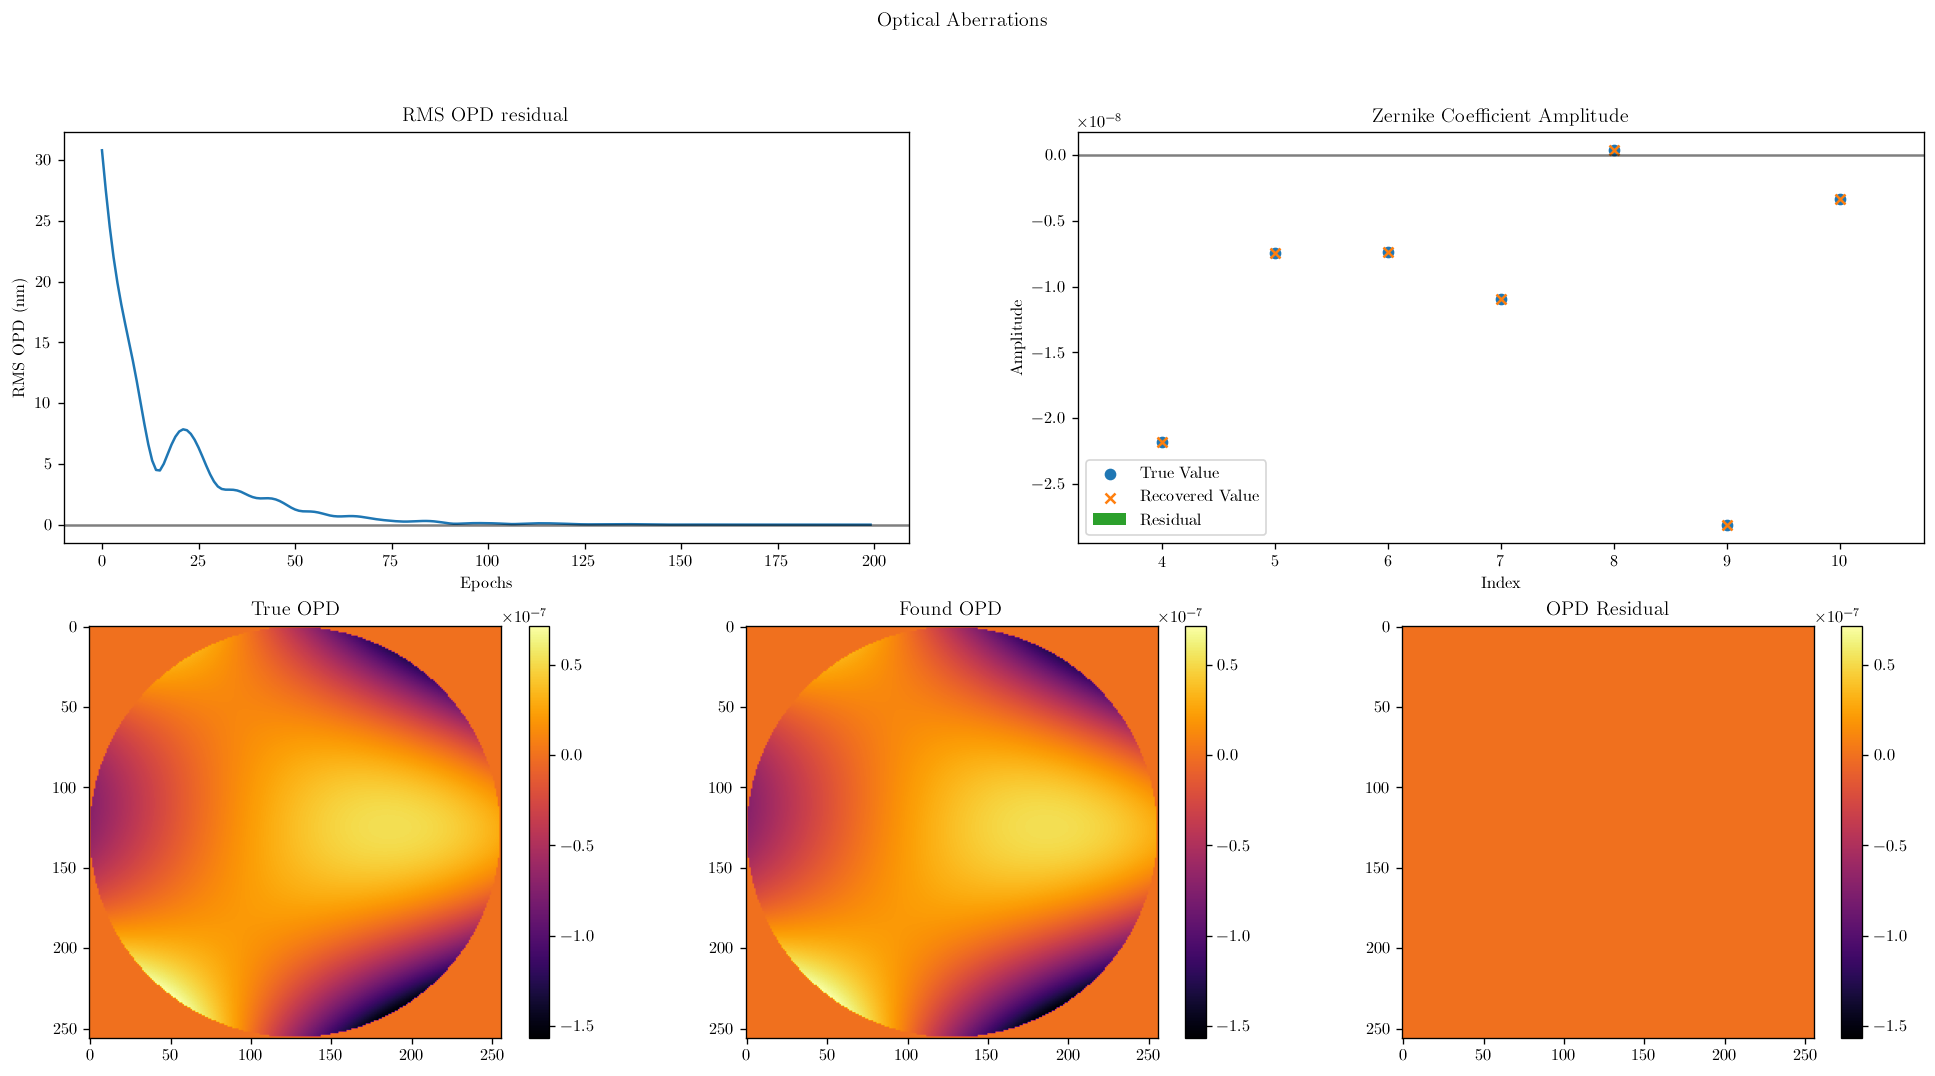

In [20]:
# OPDs
true_opd = osys.layers[-2].get_total_opd()
opds_found = np.array([models_out[i][0].layers[-2].get_total_opd()  for i in range(len(models_out))])
found_opd = opds_found[-1]
opd_residuls = true_opd - opds_found
opd_rmse_nm = 1e9*np.mean(opd_residuls**2, axis=(-1,-2))**0.5

vmin = np.min(np.array([true_opd, found_opd]))
vmax = np.max(np.array([true_opd, found_opd]))

# Coefficients
true_coeff = osys.layers[-2].coeffs
found_coeff = final_model.layers[-2].coeffs
index = np.arange(len(true_coeff))+4

plt.figure(figsize=(20, 10))
plt.suptitle("Optical Aberrations")

plt.subplot(2, 2, 1)
plt.title("RMS OPD residual")
plt.xlabel("Epochs")
plt.ylabel("RMS OPD (nm)")
plt.plot(opd_rmse_nm)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(2, 2, 2)
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.scatter(index, true_coeff, label="True Value")
plt.scatter(index, found_coeff, label="Recovered Value", marker='x')
plt.bar(index, true_coeff - found_coeff, label='Residual')
plt.axhline(0, c='k', alpha=0.5)
plt.legend()

plt.subplot(2, 3, 4)
plt.title("True OPD")
plt.imshow(true_opd)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found OPD")
plt.imshow(found_opd)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("OPD Residual")
plt.imshow(true_opd - found_opd, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

0.0041104504369903995


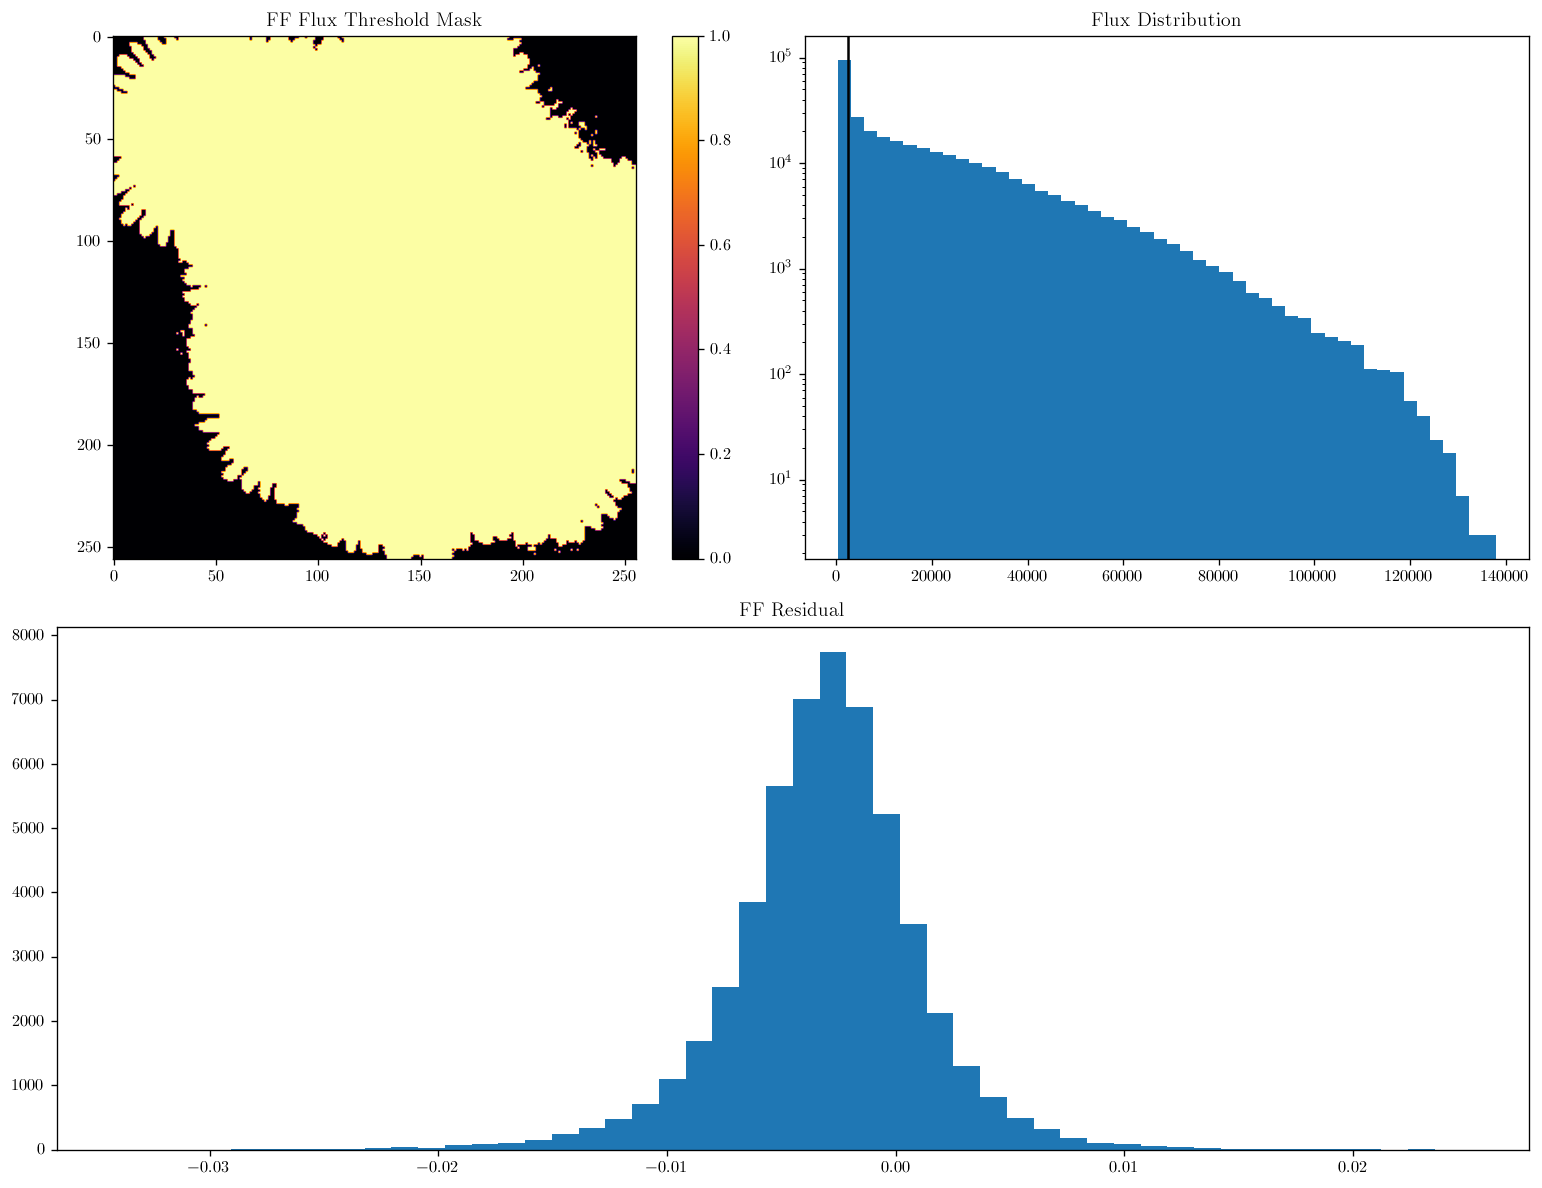

In [21]:
thresh = 2500
fmask = data.mean(0) >= thresh

out_mask = np.where(data.mean(0) < thresh)
in_mask = np.where(data.mean(0) >= thresh)

data_tile = np.tile(data.mean(0), [len(models_out), 1, 1])
in_mask_tiled = np.where(data_tile >= thresh)

plt.figure(figsize=(13, 10))
plt.subplot(2, 2, 1)
plt.title("FF Flux Threshold Mask")
plt.imshow(fmask)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Flux Distribution")
plt.hist(data.flatten(), bins=50)
plt.axvline(thresh, c='k')
plt.yscale('log')

pr_residuals = pix_response[in_mask] - prs_found[-1][in_mask]
print(np.std(pr_residuals))

plt.subplot(2, 1, 2)
plt.title("FF Residual")
plt.hist(pr_residuals, bins=50)

plt.tight_layout()
plt.show()

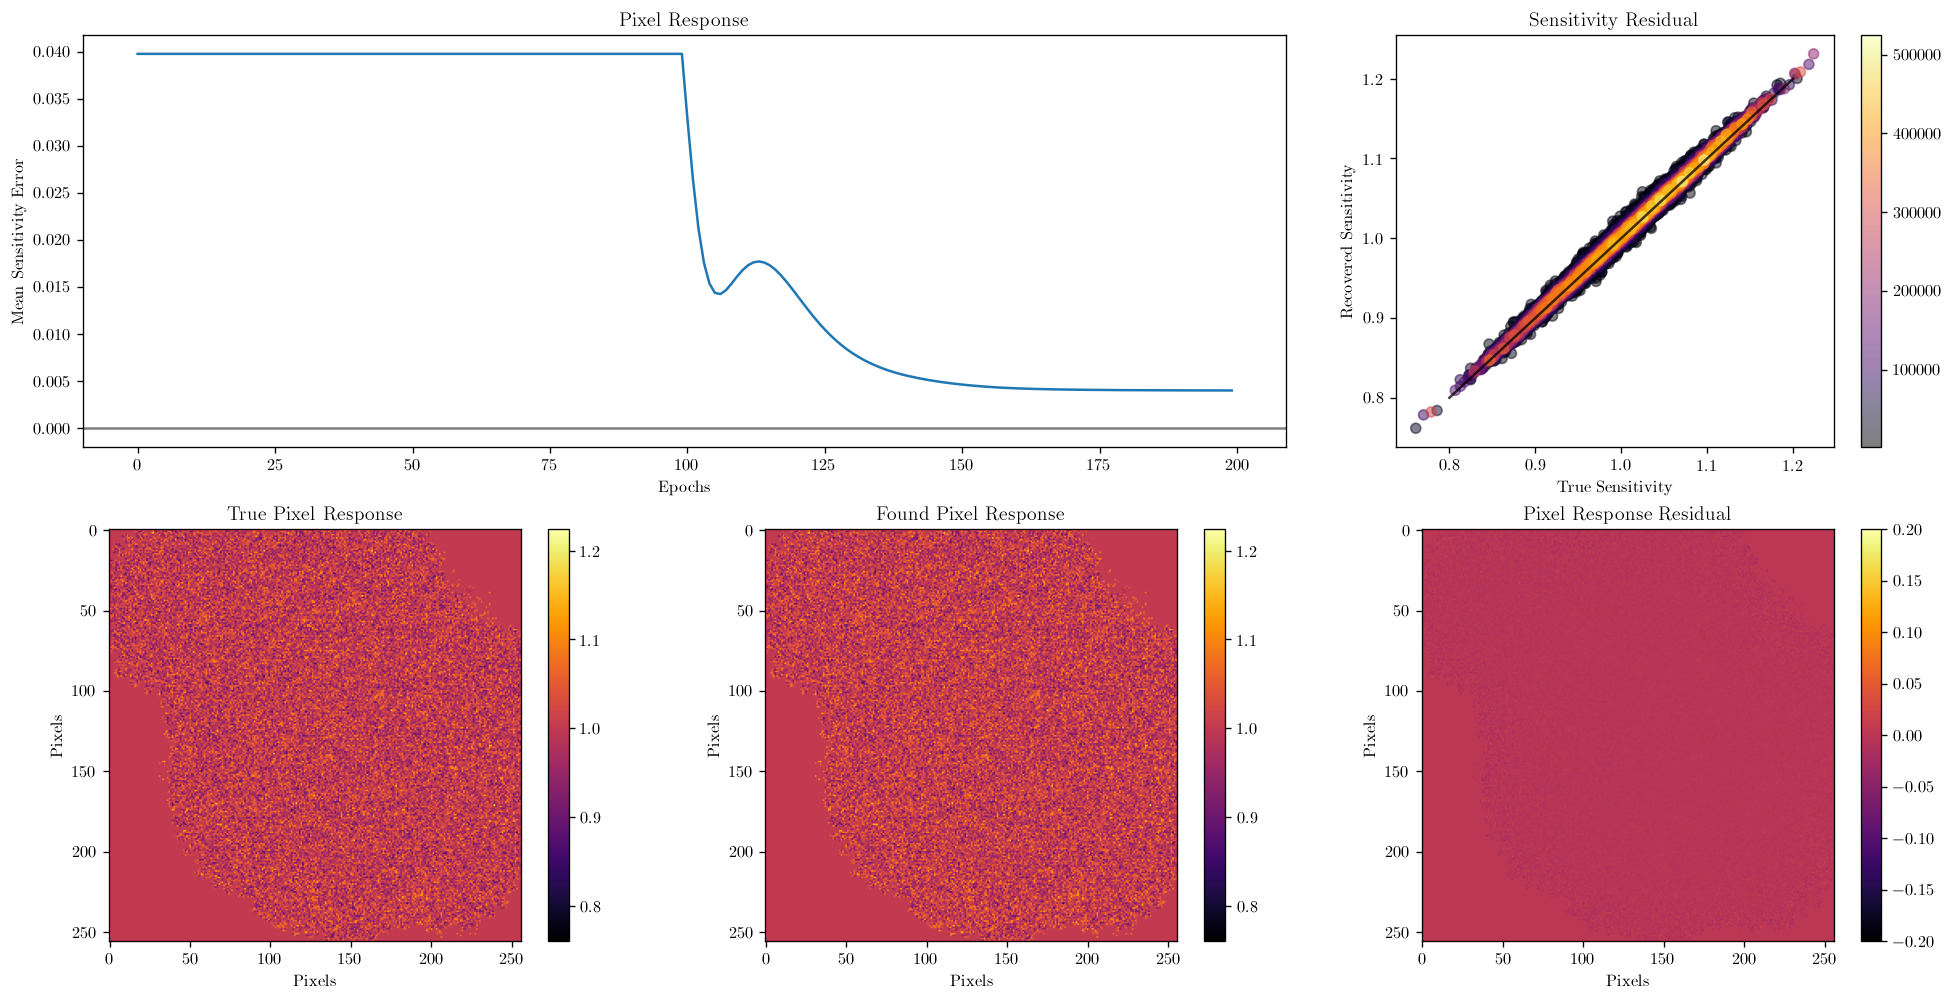

In [22]:
true_pr_masked = pix_response.at[out_mask].set(1)
found_pr_masked = prs_found[-1].at[out_mask].set(1)

# FF Scatter Plot
data_sum = data.sum(0) # [flux_mask]
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

# Errors
pfound = prs_found[in_mask_tiled].reshape([len(models_out), len(in_mask[0])])
ptrue = pix_response[in_mask]
pr_res = ptrue - pfound
masked_error = np.abs(pr_res).mean(-1)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, (1,2))
plt.title("Pixel Response")
plt.xlabel("Epochs")
plt.ylabel("Mean Sensitivity Error")
plt.plot(masked_error)
plt.axhline(0, c='k', alpha=0.5)

# FF Scatter Plot
data_sum = data.sum(0) # [flux_mask]
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

plt.subplot(2, 3, 3)
plt.plot(np.linspace(0.8, 1.2), np.linspace(0.8, 1.2), c='k', alpha=0.75)
plt.scatter(pr_true_sort, pr_found_sort, c=colours, alpha=0.5)
plt.colorbar()
plt.title("Sensitivity Residual")
plt.ylabel("Recovered Sensitivity")
plt.xlabel("True Sensitivity")

plt.subplot(2, 3, 4)
plt.title("True Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked)
plt.colorbar()

vmin = np.min(pix_response)
vmax = np.max(pix_response)

plt.subplot(2, 3, 5)
plt.title("Found Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(found_pr_masked, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("Pixel Response Residual")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked - found_pr_masked, vmin=-0.2, vmax=0.2)
plt.colorbar()

plt.show()